**Instituto de Informática - UFG**

Disciplina: Inteligência Computacional

Prof. Cedric Luiz de Carvalho


Grupo ( J )

---


Analista de dados:
* Arthur Cavalcante de Andrade
* William Teixeira Pires Junior

---

Engenheiro(a) do conhecimento:
* Arthur Cavalcante de Andrade
* William Teixeira Pires Junior

---

# Modelo

Importamos as bibliteca **pandas**, **numpy**, **seaborn** e **matplotlib.pyplot** para auxiliar nos processos de manipulação, análise de dados e criação de gráficos para visualizações de dados.

In [1]:
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

Para realizar a leitura da base de dados, atribuimos a variável `data`:

In [2]:
# leitura do arquivo .csv
data = pandas.read_csv('PS_20174392719_1491204439457_log.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


A base de dados apresenta 11 colunas, que indicam:
* `step`: em horas, desde o inicio da observação, o momento em que a transação ocorre;
* `type`: tipo de transação;
* `amount`: valor envolvido na transação;
* `nameOrig`: nome da conta que realizou a transação;
* `oldbalanceOrg`: balanço da conta de origem da transação antes da operação ser realizada;
* `newbalanceOrig`: balanço da conta de origem da transação após a operação ser realizada;
* `nameDest`: nome da conta de destino da transação;
* `oldbalanceDest`: balanço da conta de destino da transação antes da operação ser realizada;
* `newbalanceDest`: balanço da conta de destino da transação após a operação ser realizada;
* `isFraud`: se a operação foi realizada por um agente fraudulento;
* `isFlaggedFraud`: se a operação movimenta um valor acima de 200 mil em uma única transação.

In [3]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Verificamos que não ocorrem valores nulos na base de dados.

Para listar as transações em grupos distintos, com a existência ou não de fraude, utilizamos a seguinte atribuição:

In [4]:
fraud_transactions     = data.loc[data['isFraud'] == 1]
non_fraud_transactions = data.loc[data['isFraud'] == 0]

# Análise Exploratória dos Dados

### Relação de tipos de conta com `isFraud`

Dado que o campo de nome descreve o tipo de conta envolvida na transação (comerciante ou cliente), precisamos saber o quão relevantes eles são para o problema. Para isso, faremos os seguintes testes:

In [5]:
amount_merchant_orig = len(data.loc[data['nameOrig'].str.match('M')])
amount_merchant_dest = len(data.loc[data['nameDest'].str.match('M')])
amount_fraud_orig_merchant = len(fraud_transactions.loc[fraud_transactions['nameOrig'].str.match('M')])
amount_fraud_dest_merchant = len(fraud_transactions.loc[fraud_transactions['nameDest'].str.match('M')])
amount_non_fraud_orig_merchant = len(non_fraud_transactions.loc[non_fraud_transactions['nameOrig'].str.match('M')])
amount_non_fraud_dest_merchant = len(non_fraud_transactions.loc[non_fraud_transactions['nameDest'].str.match('M')])

print('---- Transações originadas de comerciantes ----')
print('                         Total: ', amount_merchant_orig)
print('         Quantidade de Fraudes: ', amount_fraud_orig_merchant)
print('     Quantidade de Não Fraudes: ', amount_non_fraud_orig_merchant)

print('---- Transações destinadas a comerciantes ----')
print('                         Total: ', amount_merchant_dest)
print('         Quantidade de Fraudes: ', amount_fraud_dest_merchant)
print('     Quantidade de Não Fraudes: ', amount_non_fraud_dest_merchant)

---- Transações originadas de comerciantes ----
                         Total:  0
         Quantidade de Fraudes:  0
     Quantidade de Não Fraudes:  0
---- Transações destinadas a comerciantes ----
                         Total:  2151495
         Quantidade de Fraudes:  0
     Quantidade de Não Fraudes:  2151495


Podemos verificar que em todas as transações em que comerciantes aparecem, são destinatários e em nenhuma ocorre fraude. 


Essa informação é interessante para a árvore de decisão, então vamos simplificar os dados removendo as colunas de nome e adicionando uma nova coluna indicando quando uma transação envolve um comerciante.

In [6]:
data['hasMerchantAccount'] = numpy.where(data['nameDest'].str.match('M'), 1, 0)
reduced_data = data.drop(columns=['nameOrig', 'nameDest'])
reduced_data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hasMerchantAccount
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,1
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,1
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,1


### Relação de `step` com `isFraud`

Como a coluna `step` indica horas desde o inicio da observação, vamos verificar como o número de transações está distribuído ao longo de dias.

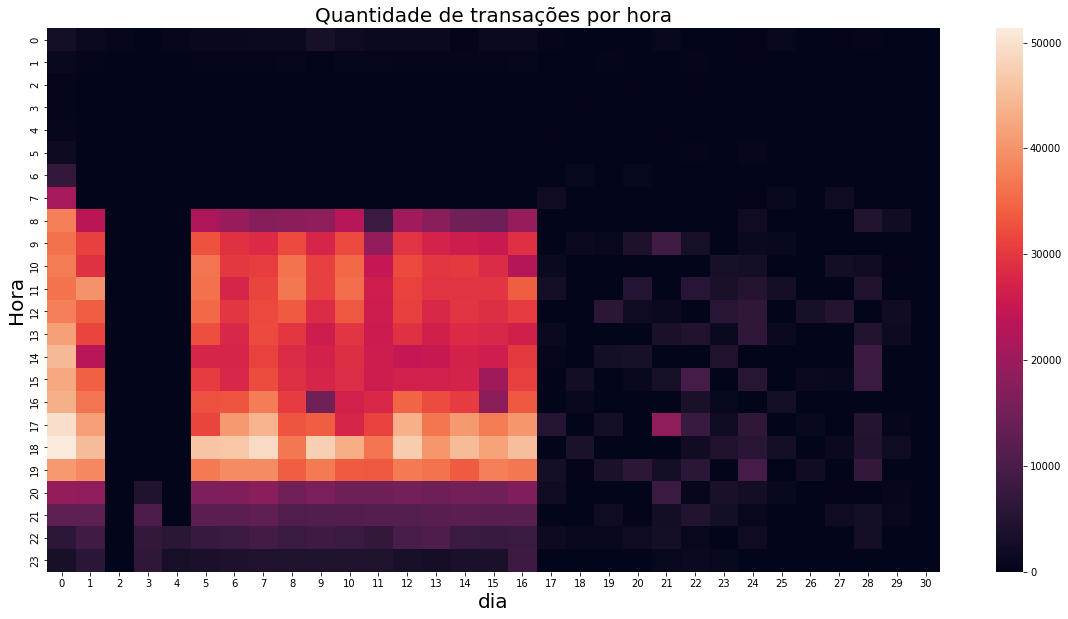

In [7]:
stepAmounts = data.groupby('step').size().array
stepAmounts = numpy.array(stepAmounts, dtype=object)
stepAmounts = numpy.append(stepAmounts, 0)  # Falta 1 hora para completar 31 dias
stepAmounts = stepAmounts.reshape(int(numpy.ceil(len(stepAmounts)/24)), 24)
stepAmounts = stepAmounts.astype(float)

fig, ax = plt.subplots(figsize=(20, 10))
ax = seaborn.heatmap(stepAmounts.T)
ax.set_ylabel('Hora', fontsize=20)
ax.set_xlabel('dia', fontsize=20)
ax.set_title('Quantidade de transações por hora', fontsize=20)
fig.savefig('transacoes_por_hora.jpg')

In [8]:
expected = 1
for i in fraud_transactions.groupby('step').size().keys():
    if i != expected:
        print('Não houve fraude na hora: ', expected)
    expected = i+1

Não houve fraude na hora:  347
Não houve fraude na hora:  545


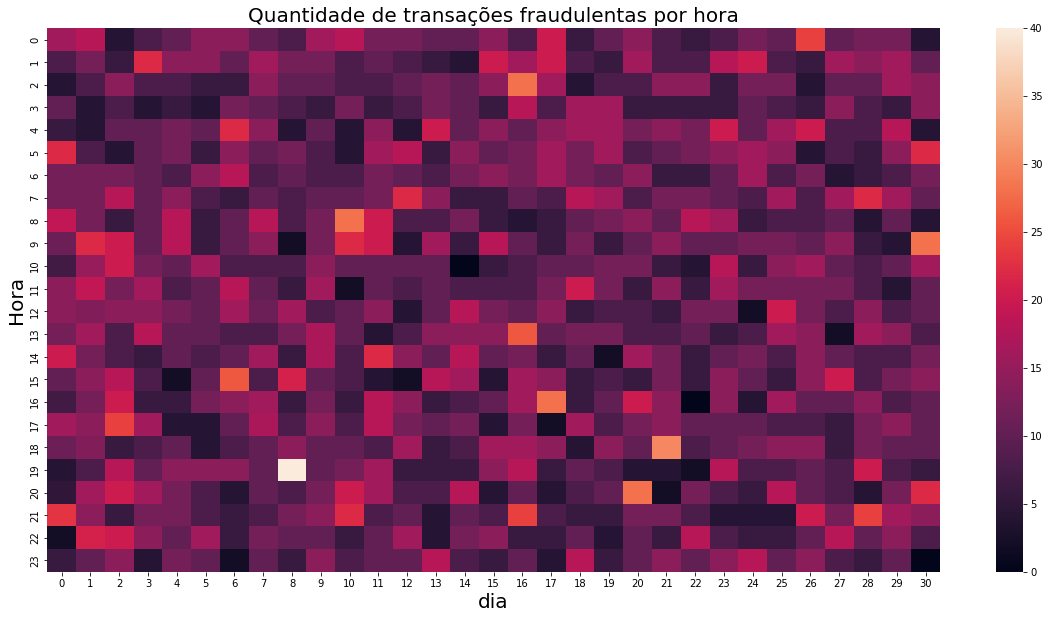

In [9]:
stepAmounts = fraud_transactions.groupby('step').size().array
stepAmounts = numpy.array(stepAmounts, dtype=object)
stepAmounts = numpy.insert(stepAmounts, 346, 0) # Não há fraude na hora 347
stepAmounts = numpy.insert(stepAmounts, 544, 0) # Não há fraude na hora 545
stepAmounts = numpy.append(stepAmounts, 0)      # Falta 1 hora para completar 31 dias
stepAmounts = stepAmounts.reshape(int(numpy.ceil(len(stepAmounts)/24)), 24)
stepAmounts = stepAmounts.astype(float)

fig, ax = plt.subplots(figsize=(20, 10))
ax = seaborn.heatmap(stepAmounts.T)
ax.set_ylabel('Hora', fontsize=20)
ax.set_xlabel('dia', fontsize=20)
ax.set_title('Quantidade de transações fraudulentas por hora', fontsize=20)
fig.savefig('transacoes_fraudulentas_por_hora.jpg')

Podemos ver que os primeiros 17 dias com exceção do terceiro, quarto e quinto dias ocorrem muitas transações por volta dos mesmos horários. No entanto, quando olhamos só para transações fraudulentas, vemos que estão distribuídas de maneira bastante uniforme. 
Logo, a coluna `step` não oferece nenhuma informação quanto se uma dada transferência é fraudulenta ou não.


No entanto, essa informação poderá ser importante no momento de escolher dados de entrada para o algoritmo de solução, logo removeremos essa coluna posteriormente.

### Relação de `type` com `isFraud`

Nesta etapa iremos avaliar a relação dos tipos de operação e as ocorrências de fraudes.


Inicialmente, descobrimos os tipos de operações existentes na base de dados, e em seguida verificamos a quantidade de ocorrência de fraudes para cada tipo encontrado:

In [10]:
transactionTypes = list(dict.fromkeys(data['type']))

for type in transactionTypes:
    print("Fraudes ocorridas como", type, ":", len(fraud_transactions.loc[fraud_transactions['type'].str.match(type)]))

Fraudes ocorridas como PAYMENT : 0
Fraudes ocorridas como TRANSFER : 4097
Fraudes ocorridas como CASH_OUT : 4116
Fraudes ocorridas como DEBIT : 0
Fraudes ocorridas como CASH_IN : 0


Percebemos que em apenas dois dos cinco tipos ocorrem fraudes: **TRANSFER** e **CASH_OUT**.

Fazendo a seguinte análise:

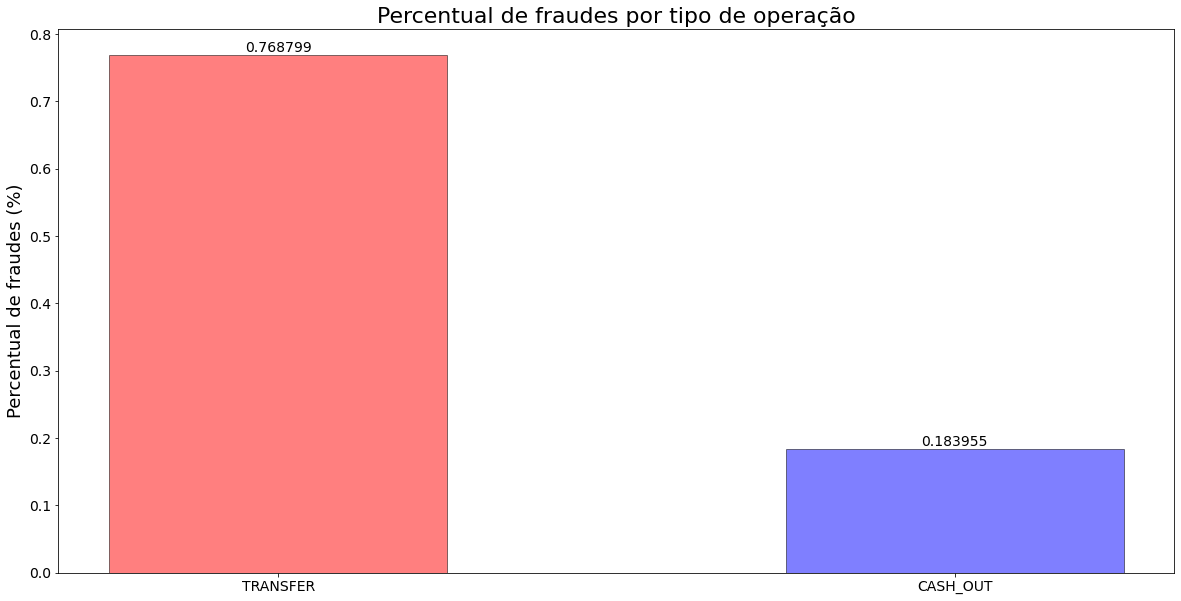

Quantidade total de operações:  6362620
Quantidade de transferências:  532909 , 8.38 % do total
Quantidade de saques:  2237500 , 35.17 % do total


In [11]:
transfer_amount = len(data.loc[data['type'].str.match('TRANSFER')])
cashout_amount = len(data.loc[data['type'].str.match('CASH_OUT')])

x_info = ['TRANSFER', 'CASH_OUT']
y_info = [4097*100/transfer_amount, 4116*100/cashout_amount]

fig, ax = plt.subplots(figsize=(20, 10))
bar = ax.bar(x_info, y_info, color=['red', 'blue'], width=0.5, align='center', alpha=0.5, edgecolor='black')
ax.bar_label(bar, fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_title('Percentual de fraudes por tipo de operação', fontsize=22)
ax.set_ylabel('Percentual de fraudes (%)', fontsize=18)
fig.savefig('percentual_fraudes_por_tipo_operacao.jpg')
plt.show()

print("Quantidade total de operações: ", len(data))
print("Quantidade de transferências: ",transfer_amount, ",", "{:.2f}".format((transfer_amount*100)/len(data)), "% do total")
print("Quantidade de saques: ",cashout_amount, ",", "{:.2f}".format((cashout_amount*100)/len(data)),"% do total")

Observamos que cerca 43.55% das operações são dos tipos **TRANSFER** e **CASH_OUT**, das quais um baixo percentual destas contém fraudes. Desta forma, a coluna `type` pode ser simplificada.

Faremos a seguinte modificação na base de dados:
* TRANSFER = 1
* CASH_OUT = 2
* DEBIT, CASH_IN, PAYMENT = 0

In [12]:
conditions = [data['type'].str.match('TRANSFER'), 
              data['type'].str.match('CASH_OUT'), 
              (data['type'].str.match('DEBIT')) | (data['type'].str.match('CASH_IN')) | (data['type'].str.match('PAYMENT'))]
choices    = [1, 2, 0]
reduced_data['simplified_type'] = numpy.select(conditions, choices)
reduced_data = reduced_data.drop(columns=['type'])
reduced_data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hasMerchantAccount,simplified_type
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,2
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0


Em adição, a coluna `isFlaggedFraud` apresenta informação redundante. Portanto, também iremos removê-la da tabela.

In [13]:
reduced_data = reduced_data.drop(columns=['isFlaggedFraud'])
reduced_data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hasMerchantAccount,simplified_type
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,2
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,1,0


In [14]:
cols = reduced_data['hasMerchantAccount']
reduced_data = reduced_data.drop(columns=['hasMerchantAccount'])
reduced_data.insert(0, 'hasMerchantAccount', cols)

cols = reduced_data['simplified_type']
reduced_data = reduced_data.drop(columns=['simplified_type'])
reduced_data.insert(1, 'simplified_type', cols)
reduced_data.head()

,hasMerchantAccount,simplified_type,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,0,1,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,0,1,1864.28,21249.0,19384.72,0.0,0.0,0
2,0,1,1,181.00,181.0,0.00,0.0,0.0,1
3,0,2,1,181.00,181.0,0.00,21182.0,0.0,1
4,1,0,1,11668.14,41554.0,29885.86,0.0,0.0,0


In [15]:
reduced_data.to_csv('reduced_data.csv', index=False)

A partir da tabela resultante, podemos seguir para a etapa de solução do problema.